In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Load and prepare data

In [2]:
## Locate files.
fdir = os.path.join('stan_results', 'recovery')
files = sorted([f for f in os.listdir(fdir) if f.endswith('csv')])

## Iteratively load files.
data = []
for f in files:
    
    ## Load file.
    df = read_csv(os.path.join(fdir, f))
    df.insert(0, 'stan_model', '_'.join(f.split('_')[:-1]))
    
    ## Append.
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)

## Compute decile of latent parameters.
f = lambda x: np.digitize(x, np.percentile(x, np.arange(10,100,10)))
data['decile'] = data.groupby('param').latent.transform(f)

## Section 2: Rank correlations

#### 2.1 Compute correlations

In [3]:
## Define correlation function.
corr = lambda x: x.corr(method='spearman').loc['latent','predicted']

## Compute rank correlations.
gb = data.groupby(['stan_model','seed','param']).apply(corr)
gb = gb.reset_index().rename(columns={0:'rho'})

#### 2.2 Plot correlations

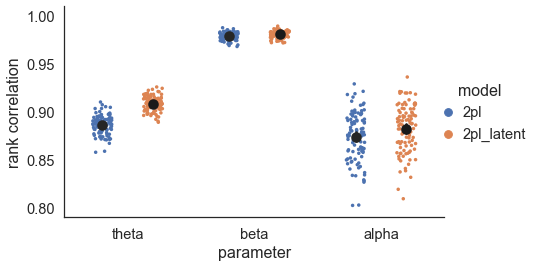

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
order = ['theta','beta','alpha']

## Plot correlations.
sns.stripplot(x='param', y='rho', hue='stan_model', data=gb, order=order, dodge=True, 
              size=3.5, jitter=0.15, zorder=-1, ax=ax)
sns.pointplot(x='param', y='rho', hue='stan_model', data=gb, order=order, dodge=0.4, 
              scale=1.2, color='k', join=False, ax=ax)

## Add detail.
ax.set(xlabel='parameter', ylim=(0.79,1.01), ylabel='rank correlation')

## Improve legend.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc=7, bbox_to_anchor=(1.25,0.5),
          title='model', handletextpad=0, frameon=False)

sns.despine()
plt.tight_layout()

## Section 3: Recovery bias

#### 3.1 Compute bias

In [5]:
## Define bias.
data['bias'] = data['predicted'] - data['latent']

## Summarize bias.
gb = data.groupby(['stan_model','seed','param']).bias.mean()
gb = gb.reset_index()

#### 3.2 Plot bias

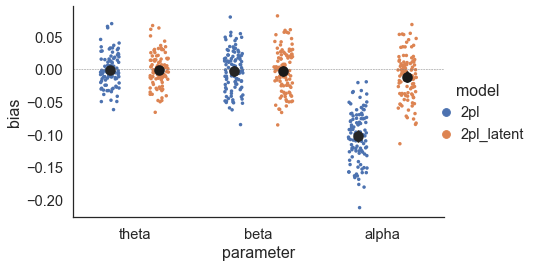

In [6]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
order = ['theta','beta','alpha']

## Plot correlations.
sns.stripplot(x='param', y='bias', hue='stan_model', data=gb, order=order, dodge=True, 
              size=3.5, jitter=0.15, zorder=-1, ax=ax)
sns.pointplot(x='param', y='bias', hue='stan_model', data=gb, order=order, dodge=0.4, 
              scale=1.2, color='k', join=False, ax=ax)

## Add detail.
ax.set(xlabel='parameter', ylabel='bias')
ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)

## Improve legend.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc=7, bbox_to_anchor=(1.25,0.5),
          title='model', handletextpad=0, frameon=False)

sns.despine()
plt.tight_layout()

#### 3.3 Plot bias by parameter decile

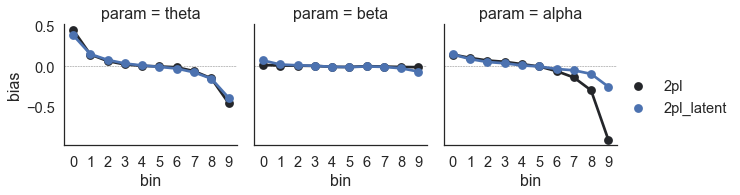

In [7]:
## Summarize variance.
gb = data.groupby(['stan_model','param','decile']).bias.mean()
gb = gb.reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, col='param', col_order=['theta','beta','alpha'])
hue_order = ['2pl','2pl_latent']

## Plot bias.
g.map(sns.pointplot, 'decile', 'bias', 'stan_model', order=np.arange(10), hue_order=hue_order)

## Add detail.
for ax in g.axes.flatten(): ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)
g.set_xlabels('bin')
g.add_legend();

## Section 3: Recovery variance

#### 3.1 Compute variance

In [8]:
## Define variance (root-mean-square).
rms = lambda x: np.sqrt(np.mean(np.square(x)))

## Summarize variance.
gb = data.groupby(['stan_model','seed','param']).bias.apply(rms)
gb = gb.reset_index()

#### 3.2 Plot variance

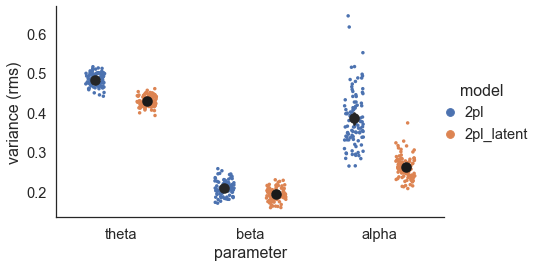

In [9]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
order = ['theta','beta','alpha']

## Plot variance.
sns.stripplot(x='param', y='bias', hue='stan_model', data=gb, order=order, dodge=True, 
              size=3.5, jitter=0.15, zorder=-1, ax=ax)
sns.pointplot(x='param', y='bias', hue='stan_model', data=gb, order=order, dodge=0.4, 
              scale=1.2, color='k', join=False, ax=ax)

## Add detail.
ax.set(xlabel='parameter', ylabel='variance (rms)')

## Improve legend.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc=7, bbox_to_anchor=(1.25,0.5),
          title='model', handletextpad=0, frameon=False)

sns.despine()
plt.tight_layout()

#### 3.3 Plot variance by parameter decile

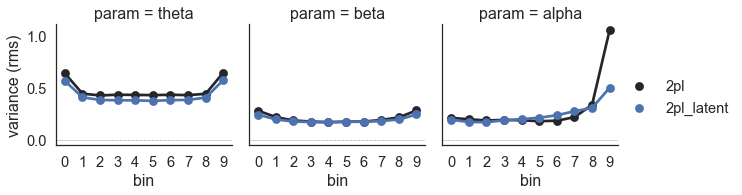

In [10]:
## Summarize variance.
gb = data.groupby(['stan_model','param','decile']).bias.apply(rms)
gb = gb.reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, col='param', col_order=['theta','beta','alpha'])
hue_order = ['2pl','2pl_latent']

## Plot bias.
g.map(sns.pointplot, 'decile', 'bias', 'stan_model', order=np.arange(10), hue_order=hue_order)

## Add detail.
for ax in g.axes.flatten(): ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)
g.set_xlabels('bin')
g.set_ylabels('variance (rms)')
g.add_legend();